# Fake News Project
# Modeling - Update After Final Report

# WORD2VEC


# Import libraries

In [1]:
#importing Libraries
import numpy as np
import pandas as pd
from matplotlib.pylab import plt
import seaborn as sns
# from sqlalchemy import create_engine
# import sqlalchemy as 
import sqlite3
import nltk
from nltk.tokenize import word_tokenize

import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import STOPWORDS,WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.metrics import f1_score

from joblib import dump, load

In [2]:
import warnings

warnings.filterwarnings(action="ignore")

# Load Dataset

In [3]:
df= pd.read_pickle("strats_new.pkl")

In [4]:
# For modeling purposes, we deleted missing values in the column "labels" (target variable). 
df.dropna(subset=['label'], axis = 0, inplace=True)

In [5]:
## calculate frequencies of labels
df["label"].value_counts()

0.0    61222
1.0    50058
Name: label, dtype: int64

In [6]:
# Create a boolean mask to select rows where the label is not equal to 2
mask = df["label"] != 2

# Use the mask to filter the DataFrame
df_no2 = df[mask]

In [7]:
# Seperating target and data
Y_no2 = df_no2["label"]
X_no2 = df_no2.drop("label", axis=1)


In [8]:
X_no2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111280 entries, 0 to 177830
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        111280 non-null  object 
 1   date                      111280 non-null  object 
 2   source                    111280 non-null  object 
 3   title                     111280 non-null  object 
 4   content                   111280 non-null  object 
 5   author                    111280 non-null  object 
 6   url                       111280 non-null  object 
 7   published                 111280 non-null  object 
 8   published_utc             111280 non-null  int64  
 9   collection_utc            111280 non-null  int64  
 10  country                   106074 non-null  object 
 11  bias                      111280 non-null  object 
 12  factuality                110158 non-null  float64
 13  questionable-source       111280 non-null  f

In [9]:
X_no2.isnull().sum()

id                             0
date                           0
source                         0
title                          0
content                        0
author                         0
url                            0
published                      0
published_utc                  0
collection_utc                 0
country                     5206
bias                           0
factuality                  1122
questionable-source            0
conspiracy-pseudoscience       0
pro-science                    0
word_count_content             0
word_count_title               0
nb_character_content           0
nb_character_title             0
dtype: int64

In [10]:
X_no2.shape

(111280, 20)

In [11]:
Y_no2.info()

<class 'pandas.core.series.Series'>
Int64Index: 111280 entries, 0 to 177830
Series name: label
Non-Null Count   Dtype  
--------------   -----  
111280 non-null  float64
dtypes: float64(1)
memory usage: 1.7 MB


In [12]:
Y_no2.isnull().sum()

0

In [13]:
Y_no2.shape

(111280,)

# WORD2VEC 
## takes 20-30 minutes overall


In [14]:
X_text2 = X_no2[["title", "content"]]

In [15]:
X_text2.shape

(111280, 2)

In [16]:
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
nltk.download("punkt")
import warnings

warnings.filterwarnings(action="ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nutzer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
title_sentences = [sent_tokenize(text) for text in X_text2["title"]]
content_sentences = [sent_tokenize(text) for text in X_text2["content"]]

tokenized_title_sentences = [[word_tokenize(sentence) for sentence in sentence_list] for sentence_list in title_sentences]
tokenized_content_sentences = [[word_tokenize(sentence) for sentence in sentence_list] for sentence_list in content_sentences]

tokenized_sentences = [sentence for sentence_list in tokenized_title_sentences + tokenized_content_sentences for sentence in sentence_list]

In [18]:
model = Word2Vec(tokenized_sentences, min_count=1, vector_size=200)
# takes 10 minutes


In [19]:
title_feature_vectors = []
content_feature_vectors = []
for title, content in zip(X_text2["title"], X_text2["content"]):
    title_words = word_tokenize(title)
    content_words = word_tokenize(content)
    title_word_vectors = [model.wv[word] for word in title_words if word in model.wv]
    content_word_vectors = [model.wv[word] for word in content_words if word in model.wv]
    if title_word_vectors:
        title_feature_vector = np.mean(title_word_vectors, axis=0)
    else:
        title_feature_vector = np.zeros(model.vector_size)
    if content_word_vectors:
        content_feature_vector = np.mean(content_word_vectors, axis=0)
    else:
        content_feature_vector = np.zeros(model.vector_size)
    title_feature_vectors.append(title_feature_vector)
    content_feature_vectors.append(content_feature_vector)

In [20]:
X_w2v = np.hstack((title_feature_vectors, content_feature_vectors))
print(X_w2v.shape)


(111280, 400)


In [21]:
Y_no2.shape

(111280,)

# Create Train / Test Datasets for Word2Vec
# X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v

In [22]:
# Split the dataset:
from sklearn.model_selection import train_test_split

In [23]:
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, Y_no2, test_size=0.2, random_state = 2)

# LIGHT GBM 500 WORD2VEC
# use saved model
# model saved as model_clf_Light_500_w2v.joblib


In [24]:
import lightgbm as lgb


In [25]:
Light_w2v = lgb.Dataset(X_train_w2v.astype(float), label=y_train_w2v.astype(float))

# Set the hyperparameters for the LightGBM model
paramsLight_w2v = {
    'boosting_type': 'gbdt',
    'objective': 'binary',  # Set the appropriate objective for your classification task
    'metric': 'binary_logloss',  # Set the appropriate metric for evaluation
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [26]:
# clf_Light_500_w2v = lgb.train(paramsLight_w2v, Light_w2v, num_boost_round=500)

# only run once
# then load saved model

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.440229 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [229]:
from joblib import dump, load

In [230]:
# LOAD SAVED MODEL
clf_Light_500_w2v = load("model_clf_Light_500_w2v.joblib")


In [97]:
y_pred_Light_500_w2v = clf_Light_500_w2v.predict(X_test_w2v)
y_pred_Light_500_w2v_binary = [round(pred) for pred in y_pred_Light_500_w2v]


In [98]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

accuracy_Light_500_w2v = accuracy_score(y_test_w2v, y_pred_Light_500_w2v_binary)
print("Accuracy LightGBM 500 w2v:", accuracy_Light_500_w2v)

# 0.841

Accuracy LightGBM 500 w2v: 0.8417056074766355


In [99]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_Light_500_w2v = f1_score(y_test_w2v, y_pred_Light_500_w2v_binary)
f1_Light_500_w2v

# 0.819

0.8193055341847464

In [100]:
print(classification_report(y_test_w2v, y_pred_Light_500_w2v_binary))

              precision    recall  f1-score   support

         0.0       0.84      0.88      0.86     12216
         1.0       0.84      0.80      0.82     10040

    accuracy                           0.84     22256
   macro avg       0.84      0.84      0.84     22256
weighted avg       0.84      0.84      0.84     22256



In [101]:
pd.crosstab(y_test_w2v, y_pred_Light_500_w2v_binary, rownames=["real"], colnames=["predict"])

predict,0,1
real,,
0.0,10746,1470
1.0,2053,7987


## SAVE LightGBM 500 rounds word2vec
## ALREADY SAVED


In [32]:
# from joblib import dump, load

In [33]:
# dump(clf_Light_500_w2v, "model_clf_Light_500_w2v.joblib")

['model_clf_Light_500_w2v.joblib']

# RANDOM FOREST WORD2VEC
# use saved model
# model saved as model_clf_rf_w2v.joblib

In [102]:
# Instantiate the model
from sklearn.ensemble import RandomForestClassifier


In [35]:
# clf_rf_w2v = RandomForestClassifier(n_jobs=-1)

# only run once
# then load saved model

In [36]:
# fit model
# clf_rf_w2v.fit(X_train_w2v, y_train_w2v)

# only run once
# then load saved model

RandomForestClassifier(n_jobs=-1)

In [103]:
from joblib import dump, load

In [104]:
# LOAD SAVED MODEL
clf_rf_w2v = load("model_clf_rf_w2v.joblib")


In [105]:
#Predict on the test set 
y_pred_rf_w2v = clf_rf_w2v.predict(X_test_w2v)

In [106]:
# get accuracy
accuracy_rf_w2v = clf_rf_w2v.score(X_test_w2v, y_test_w2v)
accuracy_rf_w2v

# 0.80

0.8049065420560748

In [107]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_rf_w2v = f1_score(y_test_w2v, y_pred_rf_w2v)
f1_rf_w2v

# 0.769

0.7695573718288928

In [108]:
# get confusion matrix
pd.crosstab(y_test_w2v, y_pred_rf_w2v, rownames=["true"], colnames=["predict"])

predict,0.0,1.0
true,,
0.0,10664,1552
1.0,2790,7250


In [109]:
from sklearn.metrics import classification_report 

# get classification report
print("Random Forest w2v classification report:\n ", classification_report (y_test_w2v, y_pred_rf_w2v))


Random Forest w2v classification report:
                precision    recall  f1-score   support

         0.0       0.79      0.87      0.83     12216
         1.0       0.82      0.72      0.77     10040

    accuracy                           0.80     22256
   macro avg       0.81      0.80      0.80     22256
weighted avg       0.81      0.80      0.80     22256



In [110]:
# create confusion matrix

from sklearn.metrics import confusion_matrix

cf_matrix_rf_w2v = confusion_matrix(y_test_w2v, y_pred_rf_w2v)
print(cf_matrix_rf_w2v)


[[10664  1552]
 [ 2790  7250]]


## SAVE Random Forest word2vec
## ALREADY SAVED


In [45]:
# from joblib import dump, load

In [46]:
# dump(clf_rf_w2v, "model_clf_rf_w2v.joblib")

['model_clf_rf_w2v.joblib']

# LOGISTIC REGRESSION WORD2VEC
# use saved model
# model saved as model_clf_LogReg_w2v.joblib


In [111]:
from sklearn.linear_model import LogisticRegression


In [48]:
# clf_LogReg_w2v = LogisticRegression(C=1.0)

# only run once
# then load saved model

In [49]:
# Fit the model on the training dataset
# clf_LogReg_w2v.fit(X_train_w2v, y_train_w2v)

# only run once
# then load saved model

LogisticRegression()

In [112]:
from joblib import dump, load

In [113]:
# LOAD SAVED MODEL
clf_LogReg_w2v = load("model_clf_LogReg_w2v.joblib")

In [114]:
# predict on test set
y_pred_LogReg_w2v = clf_LogReg_w2v.predict(X_test_w2v)


In [115]:
# get accuracy
accuracy_LogReg_w2v = clf_LogReg_w2v.score(X_test_w2v, y_test_w2v)
accuracy_LogReg_w2v

# 0.79

0.7956056793673616

In [116]:
# Evaluate the model
f1_LogReg_w2v = f1_score(y_test_w2v, y_pred_LogReg_w2v)
print("f1 score:", f1_LogReg_w2v)

# 0.76

f1 score: 0.7676117496807152


In [117]:
# get confusion matrix
pd.crosstab(y_test_w2v, y_pred_LogReg_w2v, rownames=["true"], colnames=["predict"])


predict,0.0,1.0
true,,
0.0,10194,2022
1.0,2527,7513


In [118]:
from sklearn.metrics import classification_report 

# get classification report
print("Logistic Regression w2v classification report:\n ", classification_report (y_test_w2v, y_pred_LogReg_w2v))


Logistic Regression w2v classification report:
                precision    recall  f1-score   support

         0.0       0.80      0.83      0.82     12216
         1.0       0.79      0.75      0.77     10040

    accuracy                           0.80     22256
   macro avg       0.79      0.79      0.79     22256
weighted avg       0.80      0.80      0.80     22256



In [119]:
# create confusion matrix
cf_matrix_LogReg_w2v = confusion_matrix(y_test_w2v, y_pred_LogReg_w2v)
print(cf_matrix_LogReg_w2v)


[[10194  2022]
 [ 2527  7513]]


## SAVE Logistic Regression word2vec
## ALREADY SAVED


In [57]:
# from joblib import dump, load

In [58]:
# dump(clf_LogReg_w2v, "model_clf_LogReg_w2v.joblib")

['model_clf_LogReg_w2v.joblib']

# Stacking Classifier word2vec
# takes 15 minutes
# use saved model
# model saved as sclf_w2v.joblib


In [120]:
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_validate, KFold

In [60]:
# sclf_w2v = StackingClassifier([("rf", clf_rf_w2v), ("lr", clf_LogReg_w2v)], 
                                final_estimator = clf_LogReg_w2v)


In [61]:
# sclf_w2v.fit(X_train_w2v, y_train_w2v)

# takes 15 minutes
# only run once, then use saved model

StackingClassifier(estimators=[('rf', RandomForestClassifier(n_jobs=-1)),
                               ('lr', LogisticRegression())],
                   final_estimator=LogisticRegression())

In [124]:
from joblib import dump, load

In [125]:
# LOAD SAVED MODEL
sclf_w2v = load("sclf_w2v.joblib")


In [126]:
# Make predictions on the test set
y_pred_sclf_w2v = sclf_w2v.predict(X_test_w2v)

In [127]:
# Calculate accuracy
accuracy_sclf_w2v = accuracy_score(y_test_w2v, y_pred_sclf_w2v)
accuracy_sclf_w2v

# 0.817

0.8170381020848311

In [128]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_sclf_w2v = f1_score(y_test_w2v, y_pred_sclf_w2v)
f1_sclf_w2v

# 0.79

0.792604665376388

In [129]:
# Create crosstab
pd.crosstab(y_test_w2v, y_pred_sclf_w2v, rownames=["true"], colnames=["predict"])


predict,0.0,1.0
true,,
0.0,10403,1813
1.0,2259,7781


In [130]:
from sklearn.metrics import classification_report 

# get classification report
print("Stacking Classifier w2v classification report:\n ", classification_report (y_test_w2v, y_pred_sclf_w2v))


Stacking Classifier w2v classification report:
                precision    recall  f1-score   support

         0.0       0.82      0.85      0.84     12216
         1.0       0.81      0.78      0.79     10040

    accuracy                           0.82     22256
   macro avg       0.82      0.81      0.81     22256
weighted avg       0.82      0.82      0.82     22256



In [131]:
# create confusion matrix
cf_matrix_sclf_w2v = confusion_matrix(y_test_w2v, y_pred_sclf_w2v)
print(cf_matrix_sclf_w2v)

[[10403  1813]
 [ 2259  7781]]


Confusion Matrix for Stacking Classifier model on w2v data


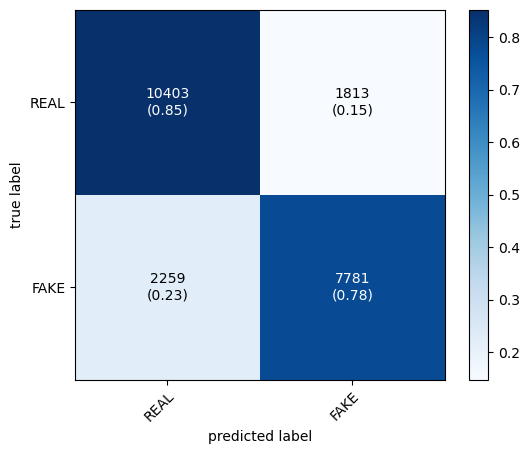

In [132]:
from mlxtend.plotting import plot_confusion_matrix

print("Confusion Matrix for Stacking Classifier model on w2v data")
plot_confusion_matrix(conf_mat = cf_matrix_sclf_w2v,
                      show_absolute=True,
                      show_normed=True,
                      colorbar=True,
                      class_names=['REAL','FAKE'])
plt.show();

## SAVE Stacking Classifier word2vec
## ALREADY SAVED


In [70]:
# from joblib import dump, load

In [71]:
# dump(sclf_w2v, "sclf_w2v.joblib")

['sclf_w2v.joblib']

# Cross-Fold word2vec
# takes a couple of hours

In [72]:
cv3 = KFold(n_splits=3, shuffle=True)

In [73]:
# sclf_w2v = StackingClassifier([("rf", clf_rf_w2v), ("lr", clf_LogReg_w2v)], 
#                                final_estimator = clf_LogReg_w2v)

In [74]:
# X_train_w2v, y_train_w2v

In [75]:
for clf, label in zip([clf_rf_w2v, clf_LogReg_w2v, sclf_w2v], ["Random Forest", "Logistic Regression", "Stacking Classifier"]):
    scores = cross_validate(clf, X_train_w2v, y_train_w2v, cv=cv3, scoring=["accuracy", "f1"])
    print(label, "accuracy: ", scores["test_accuracy"].mean(), scores["test_accuracy"].std(), "f1: ", scores["test_f1"].mean(), scores["test_f1"].std())


Random Forest accuracy:  0.8004470793613354 0.002019214258624255 f1:  0.7634466291787686 0.0018236859114945086
Logistic Regression accuracy:  0.7971108806684989 0.0016208247900923879 f1:  0.7684172873944033 0.003092828770189549
Stacking Classifier accuracy:  0.8143422302187563 0.0030524682884402595 f1:  0.7884762047003852 0.002968545311244472


# COMPARE MODELS ON TEXT DATA WORD2VEC


In [76]:
# MODELS FOR WORD2VEC:
# LightGBM 500 rounds
# Logistic Regression
# Random Forest   
# Stacking Classifier


In [133]:
print("LightGBM accuracy score word2vec 500 rounds:", accuracy_Light_500_w2v)
print("Logistic Regression accuracy score word2vec :", accuracy_LogReg_w2v)
print("Random Forest accuracy score word2vec:", accuracy_rf_w2v)
print("Stacking Classifier accuracy score word2vec:", accuracy_sclf_w2v)


LightGBM accuracy score word2vec 500 rounds: 0.8417056074766355
Logistic Regression accuracy score word2vec : 0.7956056793673616
Random Forest accuracy score word2vec: 0.8049065420560748
Stacking Classifier accuracy score word2vec: 0.8170381020848311


In [134]:
print("LightGBM f1 score word2vec 500 rounds:", f1_Light_500_w2v)
print("Logistic Regression f1 score word2vec :", f1_LogReg_w2v)
print("Random Forest f1 score word2vec:", f1_rf_w2v)
print("Stacking Classifier f1 score word2vec:", f1_sclf_w2v)


LightGBM f1 score word2vec 500 rounds: 0.8193055341847464
Logistic Regression f1 score word2vec : 0.7676117496807152
Random Forest f1 score word2vec: 0.7695573718288928
Stacking Classifier f1 score word2vec: 0.792604665376388


# PLOT WORD2VEC MODELS

In [135]:
#Creating the Dictionary with model name as key adn accuracy as key-value
labels_acc_w2 = {'LightGBM accuracy score word2vec 500 rounds:': accuracy_Light_500_w2v,
        'Logistic Regression accuracy score word2vec:': accuracy_LogReg_w2v,
        'Random Forest accuracy score word2vec:': accuracy_rf_w2v,
        'Stacking Classifier accuracy score word2vec:': accuracy_sclf_w2v}


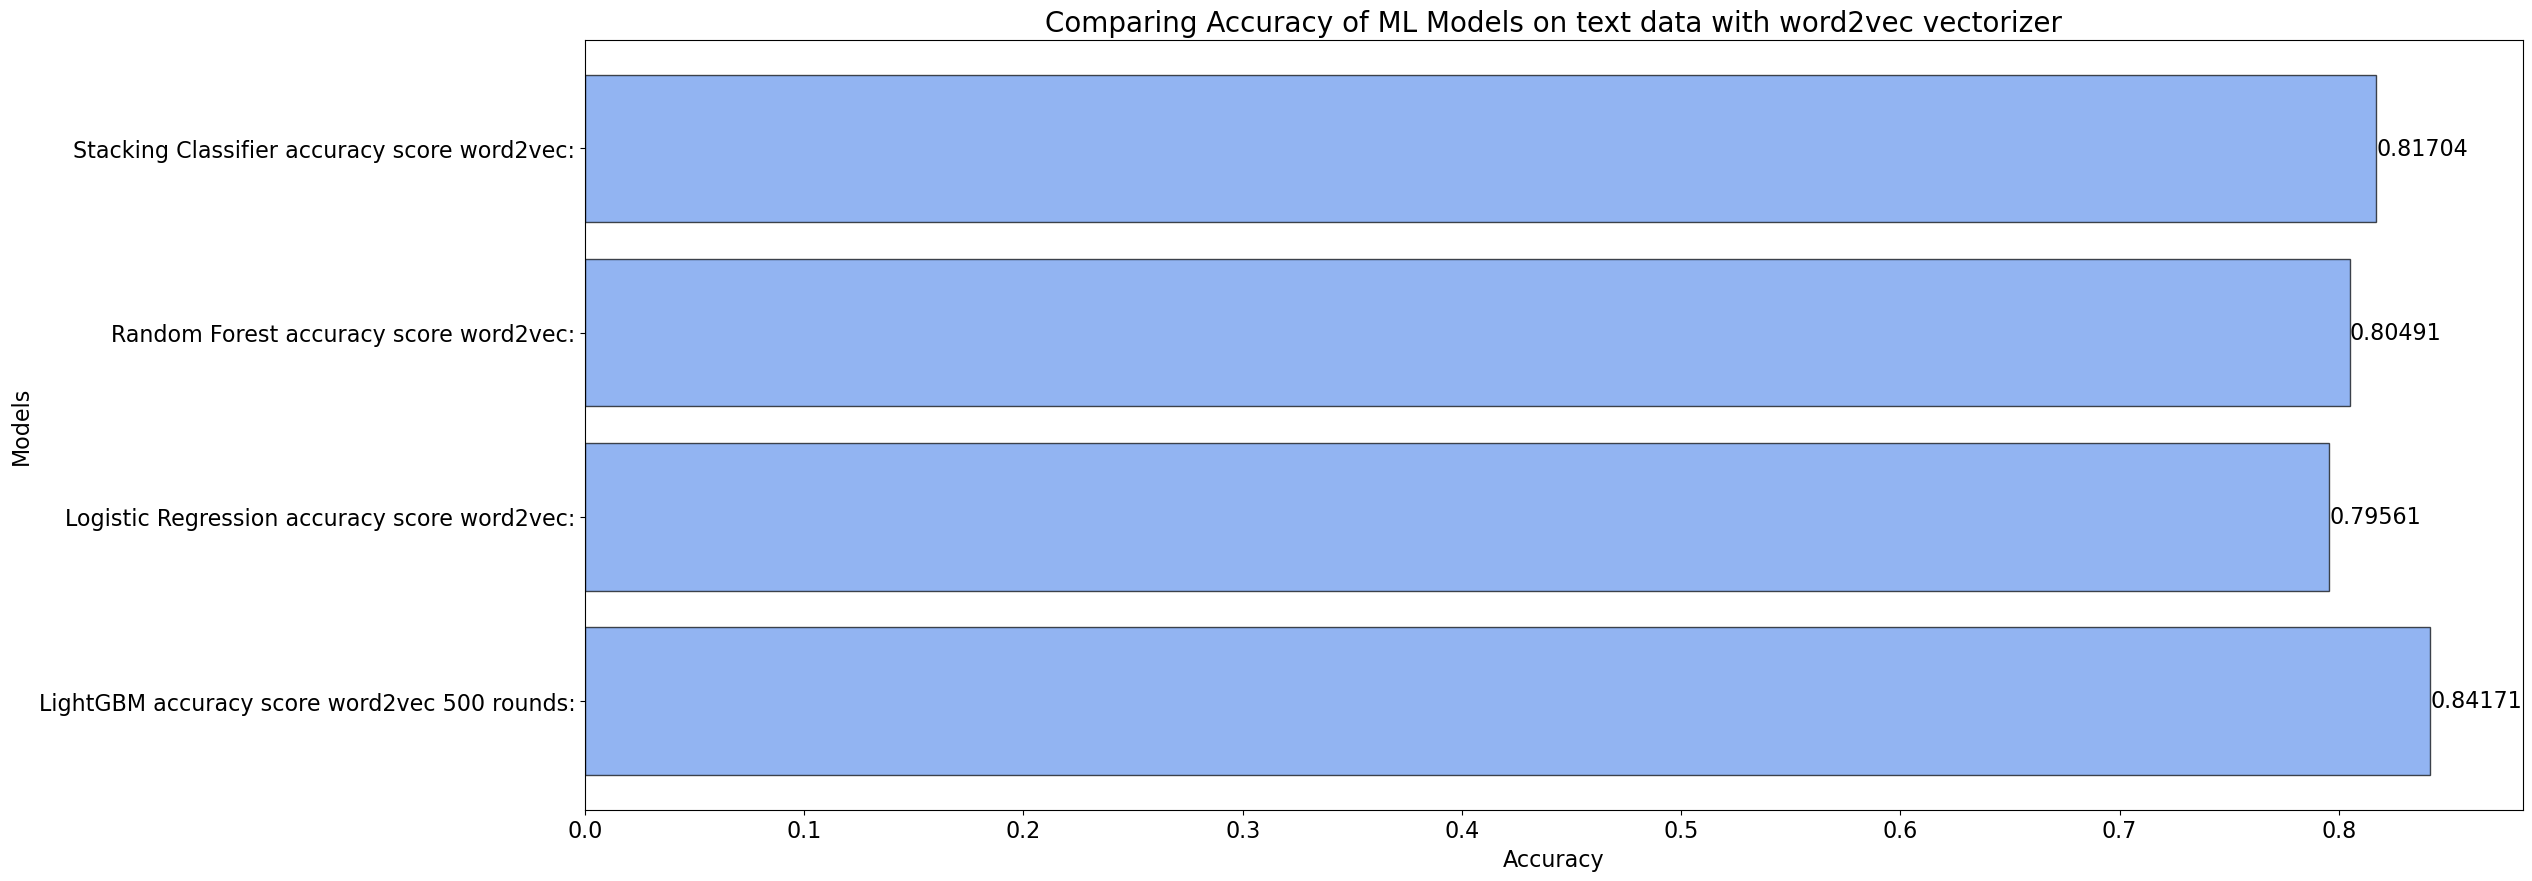

In [136]:
# Data for the chart
acc_labels_w2v = list(labels_acc_w2.keys())
acc_values_w2v = list(labels_acc_w2.values())

# Creating the chart
plt.figure(figsize=(25, 10))
plt.title('Comparing Accuracy of ML Models on text data with word2vec vectorizer', fontsize=20)
plt.xlabel('Accuracy', fontsize=16)
plt.ylabel('Models', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)# Increase the plot width to accommodate the values

plt.barh(acc_labels_w2v, acc_values_w2v, color='cornflowerblue', edgecolor='black', linewidth=1, alpha=0.7)

# Displaying values at the end of the bars
for i, value in enumerate(acc_values_w2v):
    plt.text(value, i, f'{value:.5f}', fontsize=16, va='center')

plt.show();

In [137]:
#Creating the Dictionary with model name as key adn accuracy as key-value
labels_f1_w2v = {"LightGBM f1 score word2vec 500 rounds:": f1_Light_500_w2v,
        "Logistic Regression f1 score word2vec :": f1_LogReg_w2v,
        "Random Forest f1 score word2vec:": f1_rf_w2v,
        "Stacking Classifier f1 score word2vec:": f1_sclf_w2v}


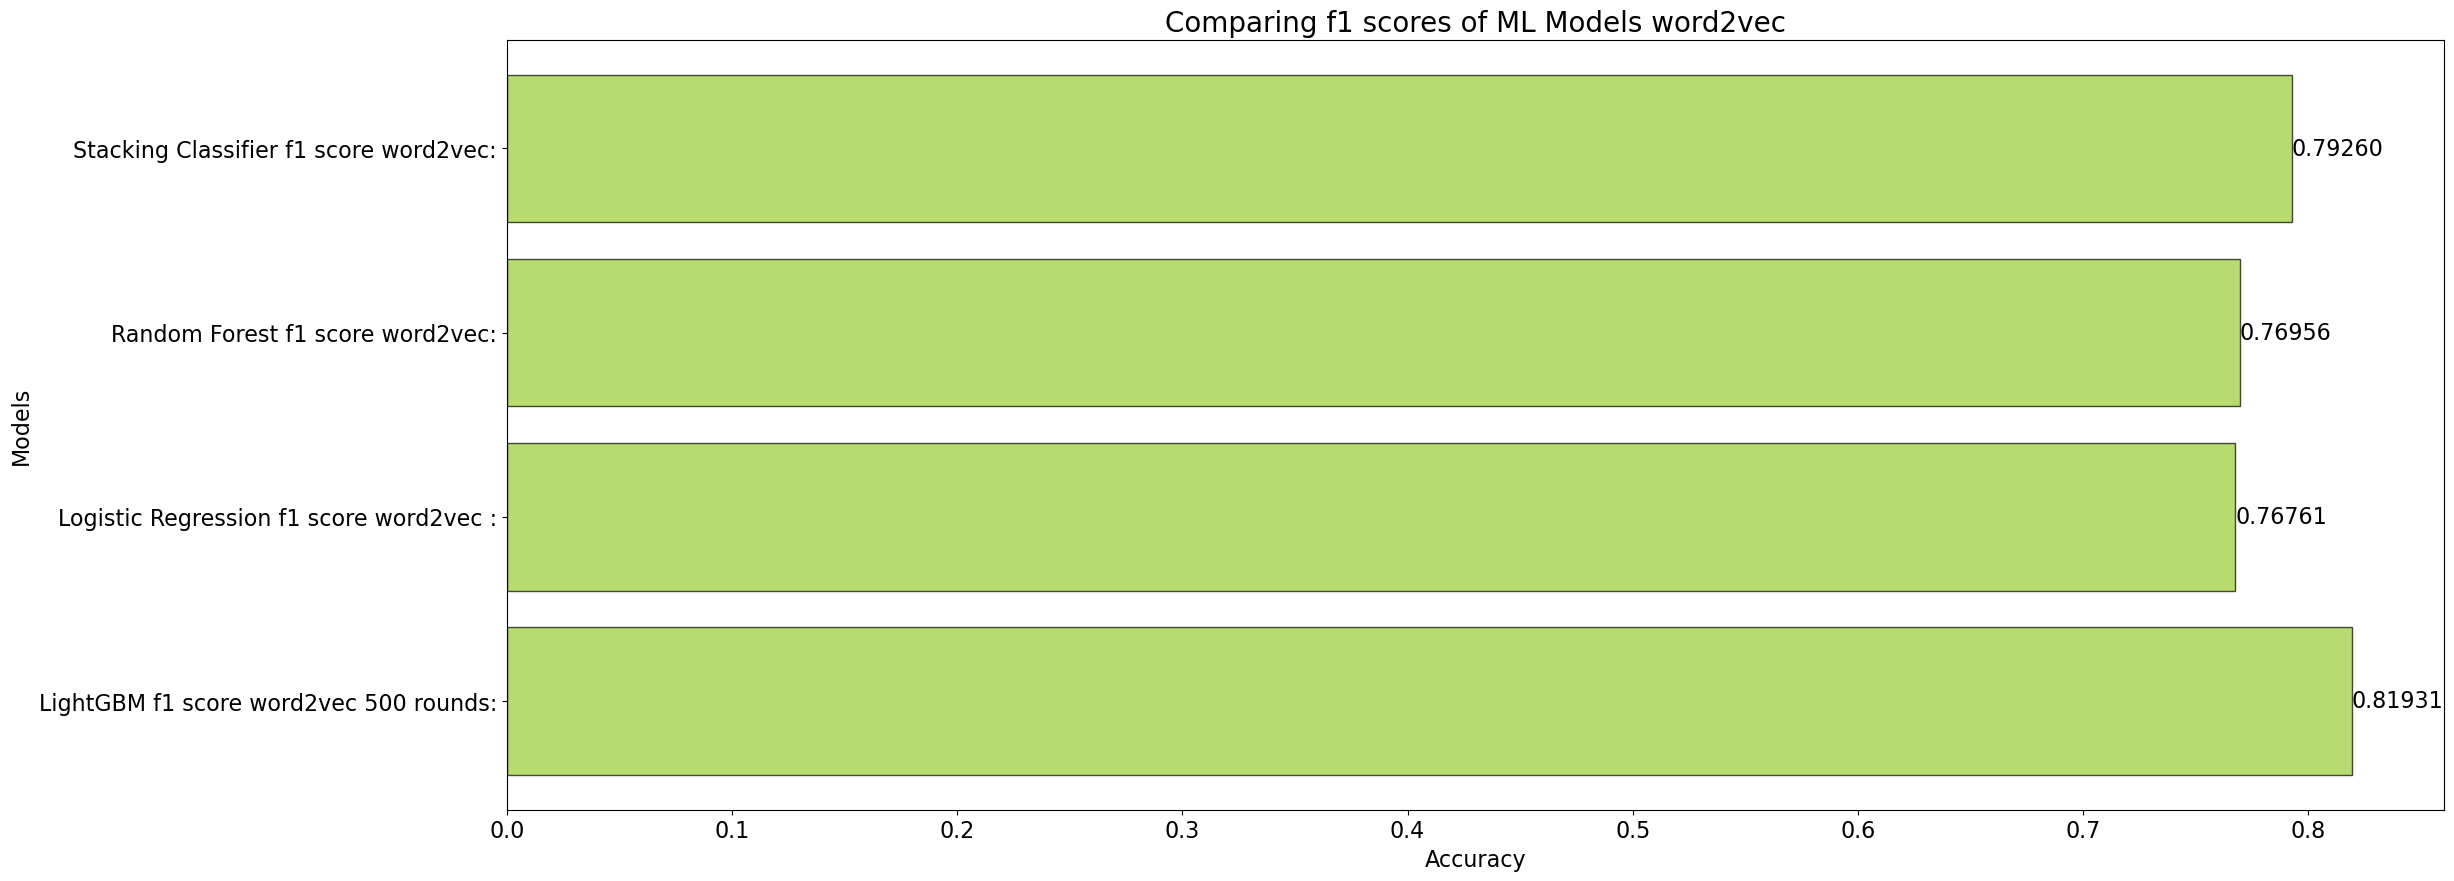

In [138]:
# Data for the chart
f1_labels_w2v = list(labels_f1_w2v.keys())
f1_values_w2v = list(labels_f1_w2v.values())

# Creating the chart
plt.figure(figsize=(25,10))
plt.title('Comparing f1 scores of ML Models word2vec',fontsize=20)
plt.xlabel('Accuracy', fontsize=16)
plt.ylabel('Models', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)# Increase the plot width to accommodate the values

plt.barh(f1_labels_w2v, f1_values_w2v, color='yellowgreen', edgecolor='black', linewidth=1, alpha=0.7)

# Displaying values at the end of the bars
for i, value in enumerate(f1_values_w2v):
    plt.text(value, i, f'{value:.5f}', fontsize=16, va='center')

plt.show();